In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import callbacks
from uproot_io import Events, View
from tensorflow.keras.models import load_model

# Building a CNN for event classification.

We're only using **perfect reconstruction** (cheated files) for this.

1. Need to obtain the truth record for each event, 0 for CC_mu, 1 for CC_e and 2 for NC_x. 


In [3]:
# the data
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [4]:
event_numbers = np.array(list(set(events.event_number)))
event_numbers, len(event_numbers)

(array([   0,    1,    2, ..., 9307, 9308, 9309], dtype=int32), 9310)

# Labelling the events

In [5]:
def labelling():
    label = []
#     bad = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])
                
#         if 13 in mcp and 11 in mcp:
#             bad.append(n)
#             label.append(3)
        
        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

In [6]:
labels = labelling()

9310


((array([3512.,    0.,    0.,    0.,    0., 3715.,    0.,    0.,    0.,
         2083.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <BarContainer object of 10 artists>),
 None)

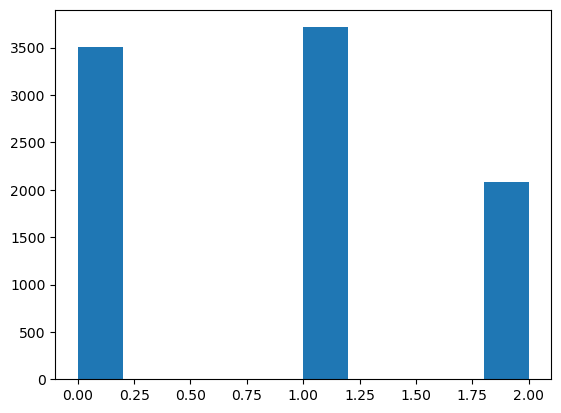

In [7]:
plt.hist(labels), print(len(labels))

In [8]:
def oneHotLabelling():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [9]:
one_hot_labels = oneHotLabelling()
one_hot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

# Making the images

In [10]:
view_w = View(events, "w")

In [11]:
def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

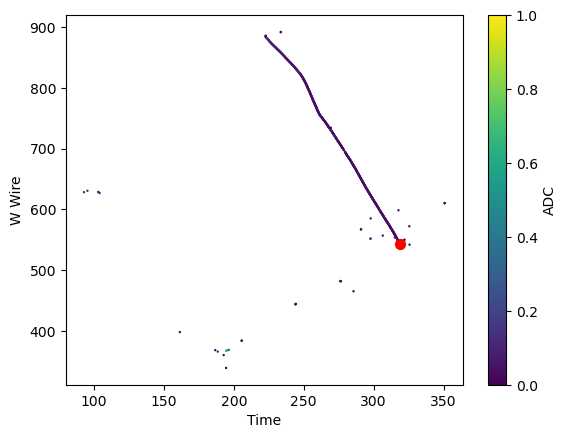

In [12]:
plot_w_event(2)

In [14]:
#image creation 1

def image():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]

        matrix_size = 128
        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)
        matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
        images.append(matrix)
        
#         matrix_size = 128
#         hit_matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)
#         hit_matrix = (hit_matrix > 0).astype(int)
#         hit_matrix = np.floor(hit_matrix).astype(np.uint8).reshape(128, 128, 1)
#         images.append(hit_matrix)
        

#         # Display the pixelated image
#         plt.imshow(hit_matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
#         plt.colorbar()
#         plt.title('Pixelated Image of Energy')
#         plt.show()
    
    return np.stack(images)

In [15]:
images = image()

In [16]:
random_numbersold = np.random.randint(0,max(event_numbers) , max(event_numbers))
seventy = int(0.7*len(random_numbersold))
training = random_numbersold[:seventy]
testing = random_numbersold[seventy:]

In [17]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [18]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [19]:
len(training), len(testing)

(6445, 2763)

In [20]:
num_classes = 3

In [21]:
# model 1

input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
# x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 3)                 381027    
                                                             

2024-02-26 15:18:35.037280: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-26 15:18:35.037470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-26 15:18:35.037479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-26 15:18:35.037666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 15:18:35.037991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [23]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [49]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)

Epoch 1/5
51/51 [==============================] - 7s 139ms/step - loss: 0.0359 - accuracy: 0.9916 - val_loss: 2.8863 - val_accuracy: 0.7528
Epoch 2/5
51/51 [==============================] - 10s 199ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 2.8284 - val_accuracy: 0.7463
Epoch 3/5
51/51 [==============================] - 12s 228ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 2.8684 - val_accuracy: 0.7394
Epoch 4/5
45/51 [=========================>....] - ETA: 0s - loss: 0.0326 - accuracy: 0.9906

KeyboardInterrupt: 

In [26]:
# cnn_model.save('modelv1')
cnn_model = load_model('modelv1')

OSError: No file or directory found at modelv1

In [50]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 0s 17ms/step
Number of images that were incorrectly classified = 695


Incorrect classification for image 1319 : predicted = 0 with true = 2


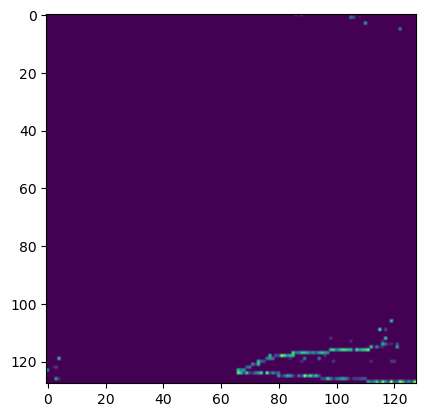

In [51]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 334
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [52]:
loss, accuracy = cnn_model.evaluate(x_test, y_test)

87/87 [==============================] - 1s 14ms/step - loss: 2.9650 - accuracy: 0.7485


In [53]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [55]:
conf_matrix_decimals

array([[0.78712871, 0.15643564, 0.05643564],
       [0.12239347, 0.79238441, 0.08522212],
       [0.12615385, 0.26      , 0.61384615]])

Text(50.722222222222214, 0.5, 'True Label')

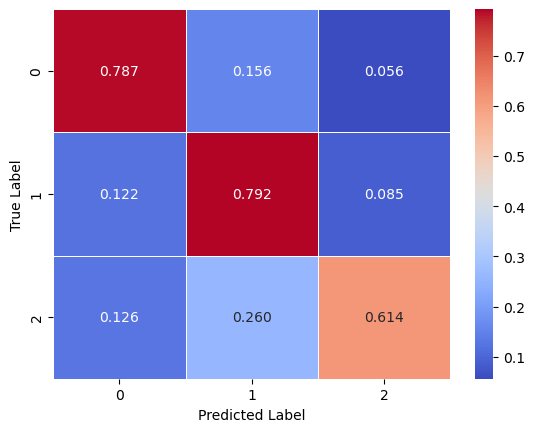

In [54]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Improved Images
This improved version uses 256 pixels, and crops the picture by centering at the mean of x and z, and allowing 150 bins above and below this mean.

In [27]:
#image creation 2

def imagenew():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        vx = view_w.true_vtx_x[n]
        vz = view_w.true_vtx_z[n]

        matrix_size = 256

        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[np.floor(np.mean(x))-150, np.floor(np.mean(x))+150], [np.floor(np.mean(z))-150, np.floor(np.mean(z))+150]], weights=adc)
        matrix = (matrix > 0).astype(int)

        matrix = np.floor(matrix).astype(np.uint8).reshape(256, 256, 1)
        images.append(matrix)
    
    return np.stack(images)

In [28]:
images = imagenew()

In [29]:
random_numbersold = np.random.randint(0,max(event_numbers) , max(event_numbers))
seventy = int(0.7*len(random_numbersold))
training = random_numbersold[:seventy]
testing = random_numbersold[seventy:]

In [30]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [31]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [32]:
len(training), len(testing)

(6445, 2763)

In [33]:
num_classes = 3

In [65]:
# same model architecture

input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
# x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 flatten_4 (Flatten)         (None, 516128)            0         
                                                                 
 dense_4 (Dense)             (None, 3)                 1548387   
                                                           

In [66]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 12
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [67]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [68]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/12
51/51 [==============================] - 46s 884ms/step - loss: 0.8256 - accuracy: 0.6408 - val_loss: 0.6659 - val_accuracy: 0.7333
Epoch 2/12
51/51 [==============================] - 42s 814ms/step - loss: 0.4172 - accuracy: 0.8607 - val_loss: 0.5690 - val_accuracy: 0.7952
Epoch 3/12
51/51 [==============================] - 44s 866ms/step - loss: 0.2367 - accuracy: 0.9320 - val_loss: 0.5381 - val_accuracy: 0.8284
Epoch 4/12
51/51 [==============================] - 59s 1s/step - loss: 0.1409 - accuracy: 0.9665 - val_loss: 0.5343 - val_accuracy: 0.8263
Epoch 5/12
51/51 [==============================] - 47s 911ms/step - loss: 0.0943 - accuracy: 0.9803 - val_loss: 0.5869 - val_accuracy: 0.8284
Epoch 6/12
13/51 [======>.......................] - ETA: 33s - loss: 0.0691 - accuracy: 0.9904

KeyboardInterrupt: 

In [75]:
# cnn_model.save('modelv2')
# cnn_model = model_load('modelv2')

INFO:tensorflow:Assets written to: modelv2/assets


INFO:tensorflow:Assets written to: modelv2/assets


In [69]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 3s 126ms/step
Number of images that were incorrectly classified = 454


Incorrect classification for image 1997 : predicted = 2 with true = 1


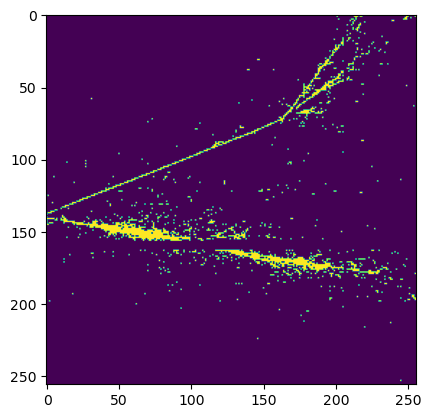

In [70]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 334
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [71]:
loss, accuracy = cnn_model.evaluate(x_test, y_test)

87/87 [==============================] - 3s 31ms/step - loss: 0.5817 - accuracy: 0.8357


In [72]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [74]:
conf_matrix_decimals

array([[0.86138614, 0.05841584, 0.08019802],
       [0.04079782, 0.86944696, 0.08975521],
       [0.08615385, 0.17538462, 0.73846154]])

Text(50.722222222222214, 0.5, 'True Label')

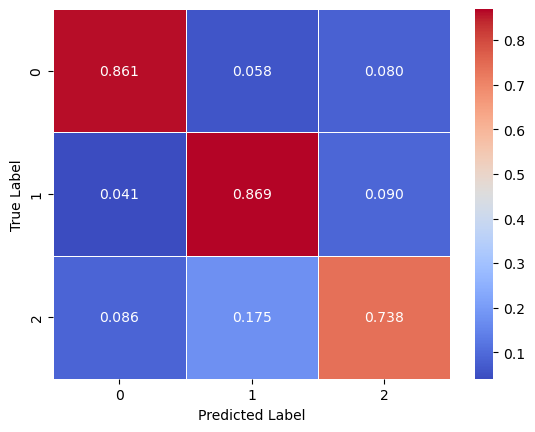

In [73]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# More changes to images

In [162]:
def imagenew():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        vx = view_w.true_vtx_x[n]
        vz = view_w.true_vtx_z[n]

        matrix_size = 256
        minusx = np.floor(np.mean(x))-100
        plusx = np.floor(np.mean(x))+100
        minusz = np.floor(np.mean(z))-100
        plusz = np.floor(np.mean(z))+100

        if vx < minusx:
            minusx = np.floor(vx)-20
            plusx = np.floor(vx)+180
        if vx > plusx:
            minusx = np.floor(vx)-180
            plusx = np.floor(vx)+20
        if vz < minusz:
            minusz = np.floor(vz)-20
            plusz = np.floor(vz)+180
        if vz > plusz:
            minusz = np.floor(vz)-180
            plusz = np.floor(vz)+20

        #range=[[np.floor(np.mean(x))-250, np.floor(np.mean(x))+250], [vz-250, vz+250]]

        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[minusx, plusx], [minusz, plusz]], weights=adc)
        matrix = (matrix > 0).astype(int)

        matrix = np.floor(matrix).astype(np.uint8).reshape(256, 256, 1)
        images.append(matrix)


    # Display the pixelated image
    #plt.imshow(matrix, cmap='viridis', origin='lower', extent=[0, 256, 0, 256])
    #plt.colorbar()
    #plt.show()
    
    return np.stack(images)

In [163]:
images = imagenew()

In [164]:
random_numbersold = np.random.randint(0,max(event_numbers) , max(event_numbers))
seventy = int(0.7*len(random_numbersold))
training = random_numbersold[:seventy]
testing = random_numbersold[seventy:]

In [165]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [166]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [167]:
len(training), len(testing)

(6445, 2763)

In [168]:
num_classes = 3

In [169]:
# same model architecture

input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
# x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 flatten_9 (Flatten)         (None, 516128)            0         
                                                                 
 dense_11 (Dense)            (None, 3)                 1548387   
                                                           

In [170]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 12
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [171]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are afew different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [172]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/12
51/51 [==============================] - 33s 643ms/step - loss: 0.8148 - accuracy: 0.6563 - val_loss: 0.6326 - val_accuracy: 0.7680
Epoch 2/12
51/51 [==============================] - 33s 649ms/step - loss: 0.3883 - accuracy: 0.8630 - val_loss: 0.5523 - val_accuracy: 0.7944
Epoch 3/12
51/51 [==============================] - 36s 714ms/step - loss: 0.2275 - accuracy: 0.9313 - val_loss: 0.5398 - val_accuracy: 0.8154
Epoch 4/12
51/51 [==============================] - 37s 731ms/step - loss: 0.1501 - accuracy: 0.9573 - val_loss: 0.5780 - val_accuracy: 0.8064
Epoch 5/12
51/51 [==============================] - 36s 698ms/step - loss: 0.1174 - accuracy: 0.9671 - val_loss: 0.5974 - val_accuracy: 0.8111
Epoch 6/12
51/51 [==============================] - 40s 779ms/step - loss: 0.0942 - accuracy: 0.9718 - val_loss: 0.6686 - val_accuracy: 0.8176
Epoch 7/12
51/51 [==============================] - 47s 921ms/step - loss: 0.0789 - accuracy: 0.9756 - val_loss: 0.6877 - val_accuracy: 0.8107

KeyboardInterrupt: 

In [173]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 3s 149ms/step
Number of images that were incorrectly classified = 501


Incorrect classification for image 1857 : predicted = 2 with true = 0


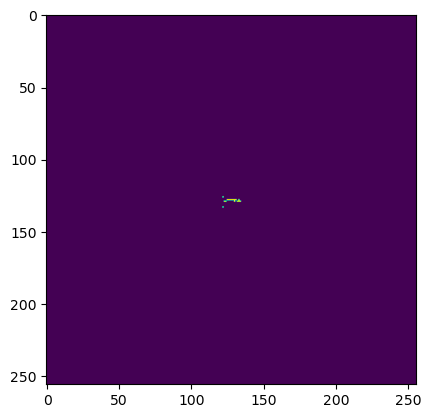

In [174]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 334
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [175]:
loss, accuracy = cnn_model.evaluate(x_test, y_test)

87/87 [==============================] - 2s 21ms/step - loss: 0.7000 - accuracy: 0.8187


In [160]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

Text(50.722222222222214, 0.5, 'True Label')

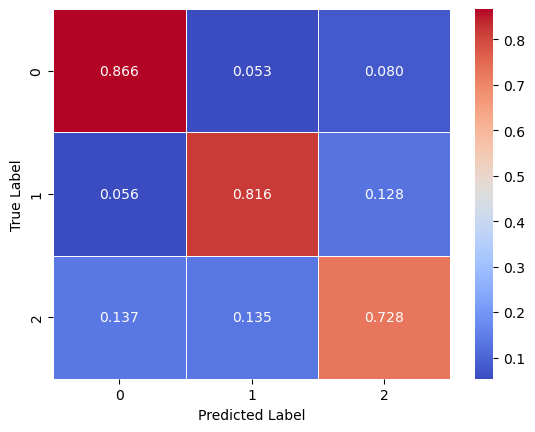

In [161]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Improved CNN Architecture

In [82]:
# model 2

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape
input_shape = x_train[0].shape  # Replace with the shape of your input data

# Input layer
input_layer = keras.layers.Input(x_train[0].shape)
# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output of the conv layers
x = Flatten()(x)
# Dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
# Output layer
output = Dense(num_classes, activation='softmax')(x)  # 3 classes for the output

# Creating the model
model = keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 128)       7385

In [109]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for - model 2, 20 is best
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [110]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [119]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
with tf.device('/cpu:0'):
    history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
                  validation_data = (x_test, y_test), verbose = 1)

Epoch 1/5
51/51 [==============================] - 226s 4s/step - loss: 0.0370 - accuracy: 0.9868 - val_loss: 1.0372 - val_accuracy: 0.8527
Epoch 2/5
51/51 [==============================] - 246s 5s/step - loss: 0.0385 - accuracy: 0.9876 - val_loss: 1.0834 - val_accuracy: 0.8393
Epoch 3/5
51/51 [==============================] - 257s 5s/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 1.1168 - val_accuracy: 0.8473
Epoch 4/5


KeyboardInterrupt: 

In [102]:
model.save('modelv3')
# model = load_model('/Users/mohammed/code/neutrinos-dune-files/modelv2')

INFO:tensorflow:Assets written to: modelv3/assets


INFO:tensorflow:Assets written to: modelv3/assets


In [120]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 5s 253ms/step
Number of images that were incorrectly classified = 617


Incorrect classification for image 21 : predicted = 0 with true = 1


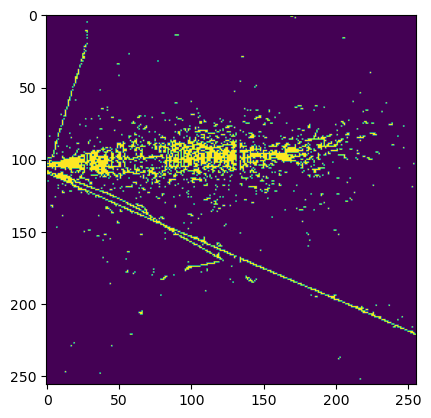

In [130]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 5
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [122]:
loss, accuracy = model.evaluate(x_test, y_test)

87/87 [==============================] - 4s 44ms/step - loss: 5.6843 - accuracy: 0.7767


In [123]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [124]:
conf_matrix_decimals

array([[0.94554455, 0.04752475, 0.00693069],
       [0.09519492, 0.89301904, 0.01178604],
       [0.27846154, 0.40461538, 0.31692308]])

Text(50.722222222222214, 0.5, 'True Label')

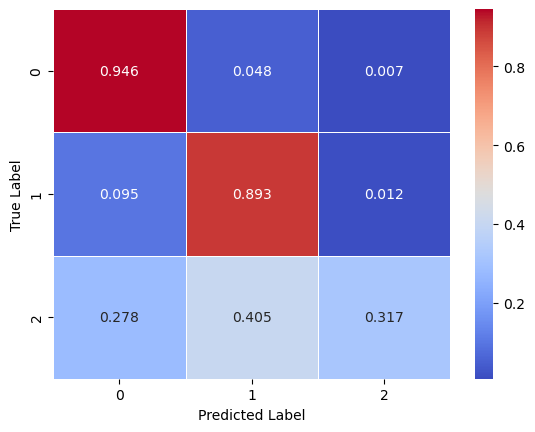

In [125]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Different Architecture

In [36]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Assuming x_train is normalized and num_classes is defined
input_shape = x_train[0].shape  # Make sure x_train is correctly preprocessed

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Model definition
input_layer = Input(shape=input_shape)

# First Conv Block with Batch Normalization and LeakyReLU
x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)  # Replace with LeakyReLU or ELU if preferred
x = MaxPooling2D((2, 2))(x)

# Second Conv Block
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Third Conv Block
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling instead of Flatten
x = GlobalAveragePooling2D()(x)

# Dense Layer with Dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Compiling the model
model = keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1849

In [37]:
# Example of how to use the data generator (Assuming x_train, y_train are prepared)
# Note: Make sure your y_train is one-hot encoded for categorical_crossentropy
datagen.fit(x_train)
with tf.device('/cpu:0'):
    model.fit(datagen.flow(x_train, y_train, batch_size=32),
              steps_per_epoch=len(x_train) / 32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2024-02-26 15:25:30.912599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-26 15:25:30.995600: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


201/201 [==============================] - 2581s 13s/step - loss: 0.9281 - accuracy: 0.6487 - val_loss: 1.3018 - val_accuracy: 0.2519
Epoch 2/10
201/201 [==============================] - 464s 2s/step - loss: 0.8098 - accuracy: 0.7071 - val_loss: 1.0425 - val_accuracy: 0.5020
Epoch 3/10
201/201 [==============================] - 451s 2s/step - loss: 0.7839 - accuracy: 0.7032 - val_loss: 3.1282 - val_accuracy: 0.3655
Epoch 4/10
201/201 [==============================] - 440s 2s/step - loss: 0.7544 - accuracy: 0.7181 - val_loss: 5.6149 - val_accuracy: 0.3655
Epoch 5/10
201/201 [==============================] - 463s 2s/step - loss: 0.7406 - accuracy: 0.7224 - val_loss: 1.1081 - val_accuracy: 0.5302
Epoch 6/10
201/201 [==============================] - 443s 2s/step - loss: 0.7281 - accuracy: 0.7246 - val_loss: 0.7271 - val_accuracy: 0.7155
Epoch 7/10
201/201 [==============================] - 524s 3s/step - loss: 0.7213 - accuracy: 0.7316 - val_loss: 1.8772 - val_accuracy: 0.3681
Epoch 8/